# Predicting if the given review is a positive review or a negative review

In [1]:
#importing necessary modules
import pandas as pd 
import re
import matplotlib.pyplot as plt
#import gensim
import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

In [2]:
#reading the dataset "movie.csv"
data = pd.read_csv('movie.csv')
data

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [3]:
#Function to name 0 as Negative and 1 as Positive
def put_sentiment(x):
    if x==0:
        return 'Negative'
    if x==1:
        return 'Positive'

In [4]:
#Adding a new column to the dataset
data['Sentiment'] = data['label'].apply(put_sentiment)
data

,text,label,Sentiment
0,I grew up (b. 1965) watching and loving the Th...,0,Negative
1,"When I put this movie in my DVD player, and sa...",0,Negative
2,Why do people who do not know what a particula...,0,Negative
3,Even though I have great interest in Biblical ...,0,Negative
4,Im a die hard Dads Army fan and nothing will e...,1,Positive
...,...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1,Positive
39996,This movie is an incredible piece of work. It ...,1,Positive
39997,My wife and I watched this movie because we pl...,0,Negative
39998,"When I first watched Flatliners, I was amazed....",1,Positive


# Exploratory Data Analysis

In [5]:
#To check number of negative comments and number of positive comments in the dataset
data.groupby('Sentiment').nunique()

,text,label
Sentiment,,
Negative,19815,1
Positive,19908,1


This implies that we have a balanced distribution of sentiments across the Imdb reviews available in the dataset

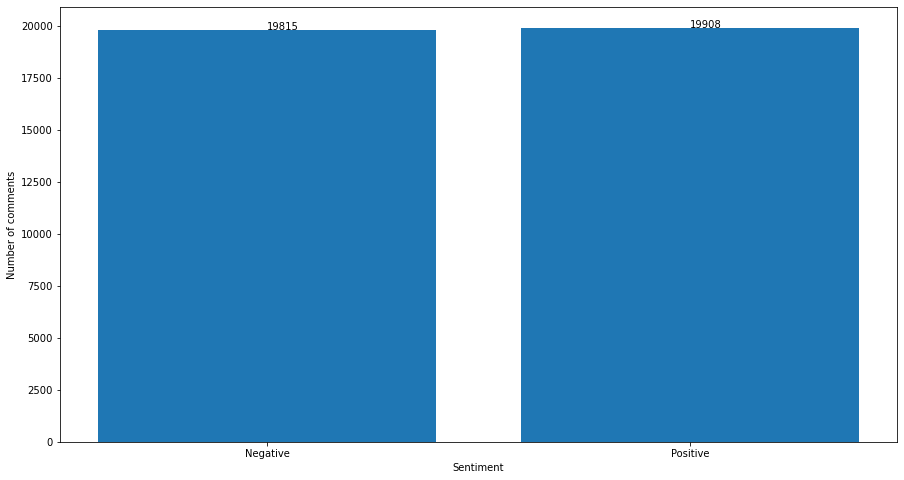

In [6]:
lis1a = ["Negative", "Positive"]
lis2a = [19815, 19908]

x = lis1a
y = lis2a

f1 = plt.figure()
f1.set_figwidth(15)
f1.set_figheight(8)
  
plt.xlabel('Sentiment')
plt.ylabel('Number of comments')
for a,b in zip(lis1a, lis2a): 
    plt.text(a, b, str(round(b,3)))

plt.bar(x, y)
plt.show()

In [7]:
#Let's check with the text column to understand if there exists any null entries
sum(data['text'].isna())

0

In [8]:
df = data.copy()
df.head()

,text,label,Sentiment
0,I grew up (b. 1965) watching and loving the Th...,0,Negative
1,"When I put this movie in my DVD player, and sa...",0,Negative
2,Why do people who do not know what a particula...,0,Negative
3,Even though I have great interest in Biblical ...,0,Negative
4,Im a die hard Dads Army fan and nothing will e...,1,Positive


# Preprocessing the data

In [9]:
def preprocess_sentence(x):
    x = re.sub('[^A-Za-z]+', ' ', x) #removing everything other than alphabet
    x = re.sub(r' \w{1} |^\w{1} | \w{1}$', ' ', x).strip() # removing all the single letter words
    x = x.lower() #coverting all the words to lowercase
    return x

In [10]:
#Adding a new column with the processed text/comment
df['preprocessed_text'] = df['text'].apply(preprocess_sentence) 
df.head()

,text,label,Sentiment,preprocessed_text
0,I grew up (b. 1965) watching and loving the Th...,0,Negative,grew up watching and loving the thunderbirds a...
1,"When I put this movie in my DVD player, and sa...",0,Negative,when put this movie in my dvd player and sat d...
2,Why do people who do not know what a particula...,0,Negative,why do people who do not know what particular ...
3,Even though I have great interest in Biblical ...,0,Negative,even though have great interest in biblical mo...
4,Im a die hard Dads Army fan and nothing will e...,1,Positive,im die hard dads army fan and nothing will eve...


In [11]:
#printing the preprocessed data for our reference
data = np.array(df['preprocessed_text'])
data[:5]

array(['grew up watching and loving the thunderbirds all my mates at school watched we played thunderbirds before school during lunch and after school we all wanted to be virgil or scott no one wanted to be alan counting down from became an art form took my children to see the movie hoping they would get glimpse of what loved as child how bitterly disappointing the only high point was the snappy theme tune not that it could compare with the original score of the thunderbirds thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created jonatha frakes should hand in his directors chair his version was completely hopeless waste of film utter rubbish cgi remake may be acceptable but replacing marionettes with homo sapiens subsp sapiens was huge error of judgment',
       'when put this movie in my dvd player and sat down with coke and some chips had some expectations was hoping that this movie would contain some of the stron

In [12]:
#doing one-hot encoding (optional as the output is binary anyways)
labels = tf.keras.utils.to_categorical(np.array(df['label']), 2, dtype="float32")
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [13]:
from keras.models import Sequential #to create model
from keras import layers #to add layers
from tensorflow.keras.optimizers import RMSprop,Adam #optimizers
from keras_preprocessing.text import Tokenizer #to tokenize the sentences
from keras_preprocessing.sequence import pad_sequences #for padding 
from keras import regularizers #adds some penalities on layer activity during optimization
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout #importing different types of layers
#from keras import backend as K
from keras.callbacks import ModelCheckpoint 

In [14]:
max_words = 5000 #maximum number of words to keep in the internal vocabulary
max_len = 200
#tokenizer allows us to convert a text into a set of integer values or a vector (vectorization)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data) #update the internal vocabulary based on the input data
sequences = tokenizer.texts_to_sequences(data) #transforms each text to a sequence of integers
tweets = pad_sequences(sequences, maxlen=max_len) 
#maxlen: Optional Int, maximum length of all sequences. If not provided, sequences will be padded to the length of the longest individual sequence.
print(tweets)

[[   0    0    0 ...   11  616    3]
 [ 801 1039    6 ...   37   19  233]
 [   0    0    0 ...    1   17 2249]
 ...
 [   0    0    0 ... 4679  766   30]
 [   0    0    0 ...   65    6    6]
 [   0    0    0 ...  331   56  916]]


In [15]:
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test)) #x_train, y_train, x_test, y_test split

30000 10000 30000 10000


In [17]:
#MODEL1

#simple model with 2 LSTM layers and 1 output layer
model1 = Sequential()
#Embedding allows in representation of similar words with similar encoding
model1.add(layers.Embedding(max_words, 20)) #parameters in embedding layer are: number of words in our intenal vocabulary and length of the vector we want to assign to each word in the sentece.
model1.add(layers.LSTM(6,dropout=0.25, return_sequences=True))
model1.add(Dropout(0.4))
model1.add(layers.LSTM(2,dropout=0.25))
model1.add(Dropout(0.4))
model1.add(layers.Dense(2,activation='softmax'))

In [20]:
model1.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          100000    
                                                                 
 lstm (LSTM)                 (None, None, 6)           648       
                                                                 
 dropout (Dropout)           (None, None, 6)           0         
                                                                 
 lstm_1 (LSTM)               (None, 2)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 2)                 6         
                                                                 
Total params: 100,726
Trainable params: 100,726
Non-trai

In [21]:
checkpoint1 = ModelCheckpoint("Imdb_senti_best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/10
938/938 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.7360
Epoch 1: val_accuracy improved from -inf to 0.85380, saving model to Imdb_senti_best_model1.hdf5
938/938 [==============================] - 276s 283ms/step - loss: 0.5585 - accuracy: 0.7360 - val_loss: 0.4126 - val_accuracy: 0.8538
Epoch 2/10
938/938 [==============================] - ETA: 0s - loss: 0.4208 - accuracy: 0.8137
Epoch 2: val_accuracy improved from 0.85380 to 0.86800, saving model to Imdb_senti_best_model1.hdf5
938/938 [==============================] - 269s 287ms/step - loss: 0.4208 - accuracy: 0.8137 - val_loss: 0.3522 - val_accuracy: 0.8680
Epoch 3/10
938/938 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.8247
Epoch 3: val_accuracy improved from 0.86800 to 0.87510, saving model to Imdb_senti_best_model1.hdf5
938/938 [==============================] - 258s 275ms/step - loss: 0.3717 - accuracy: 0.8247 - val_loss: 0.3116 - val_accuracy: 0.8751
Epoch 4/10

In [16]:
#MODEL 2

model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(10,dropout=0.25, return_sequences=True))
#model1.add(Dropout(0.4))
model1.add(layers.LSTM(10,dropout=0.25, return_sequences=True))
model1.add(layers.LSTM(10, dropout=0.25, return_sequences=True))
model1.add(layers.Bidirectional(LSTM(6, dropout=0.3, return_sequences=True)))
model1.add(layers.LSTM(10, dropout=0.25))
model1.add(Dropout(0.4))
model1.add(layers.Dense(2,activation='softmax'))

In [17]:
model1.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          100000    
                                                                 
 lstm (LSTM)                 (None, None, 10)          1240      
                                                                 
 lstm_1 (LSTM)               (None, None, 10)          840       
                                                                 
 lstm_2 (LSTM)               (None, None, 10)          840       
                                                                 
 bidirectional (Bidirectiona  (None, None, 12)         816       
 l)                                                              
                                                                 
 lstm_4 (LSTM)               (None, 10)                920       
                                                        

In [20]:
checkpoint1 = ModelCheckpoint("Imdb_senti_best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/10
938/938 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.7984
Epoch 1: val_accuracy improved from -inf to 0.82740, saving model to Imdb_senti_best_model1.hdf5
938/938 [==============================] - 297s 303ms/step - loss: 0.4523 - accuracy: 0.7984 - val_loss: 0.4116 - val_accuracy: 0.8274
Epoch 2/10
938/938 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8780
Epoch 2: val_accuracy improved from 0.82740 to 0.87280, saving model to Imdb_senti_best_model1.hdf5
938/938 [==============================] - 302s 322ms/step - loss: 0.3216 - accuracy: 0.8780 - val_loss: 0.3075 - val_accuracy: 0.8728
Epoch 3/10
938/938 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.8908
Epoch 3: val_accuracy did not improve from 0.87280
938/938 [==============================] - 390s 416ms/step - loss: 0.2879 - accuracy: 0.8908 - val_loss: 0.3551 - val_accuracy: 0.8578
Epoch 4/10
938/938 [==============================] - ETA: 

In [21]:
best_model = keras.models.load_model("Imdb_senti_best_model1.hdf5")

In [23]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

313/313 - 51s - loss: 0.3158 - accuracy: 0.8792 - 51s/epoch - 163ms/step
Model accuracy:  0.8791999816894531


In [24]:
predictor = best_model.predict(X_test)

313/313 [==============================] - 58s 166ms/step


In [25]:
sentiment = {1:'Positive', 0:'Negative'}

In [26]:
sequence = tokenizer.texts_to_sequences(['I watched that comedy drama the other day which was so boring and tiring'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 1s 787ms/step


'Negative'

In [28]:
sequence = tokenizer.texts_to_sequences(['The movie is awesome, the actors are so good'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 144ms/step


'Positive'